# Tutorial for spatial neighborhood analysis (SNA) & spatial co-localization score (sCLS) using 10X public data

**Author:**  
**Jun Inamo**  
_Computational Omics and Systems Immunology (COSI) Lab_  
_Division of Rheumatology and Center for Health AI_  
_University of Colorado School of Medicine, CO, USA_  
📧 jun.inamo@cuanschutz.edu

In [1]:
format(Sys.time(), '%d %B, %Y')

[1] "04 April, 2025"

In [2]:
library(Seurat)
library(magrittr)
library(dplyr)
# devtools::install_github("zhanghao-njmu/SCP")
library(SCP)
library(ggplot2)
library(circlize)
library(ComplexHeatmap)

library(spatialCooccur)

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
  my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
  nn.ranked <- my.knn$nn.idx
  
  snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
  rownames(snn_res) <- row.names(data.use)
  colnames(snn_res) <- row.names(data.use)
  return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.3.3"
Loading required package: sp


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




SCP python environment not found.

If you have already created an SCP python environment using conda, you can specify the conda path by setting options(reticulate.conda_binary = "/path/to/conda", SCP_env_name = "SCP_env") before loading the package.

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular 

# Xenium Human Breast Gene Expression


## Preprocessing & Cell annotation

In [ ]:

path <- "/path/to/10X_Xenium_sample/Xenium_V1_human_Breast_2fov_outs/"
data_name = stringr::str_split(path, "/")[[1]][length(stringr::str_split(path, "/")[[1]])-1]

# Load the Xenium data
data <- ReadXenium(path, outs = c("matrix", "microns"), type = c("centroids", "segmentations"))
## continue the regular LoadXenium
segmentations.data <- list(
  centroids = CreateCentroids(data$centroids),
  segmentation = CreateSegmentation(data$segmentations))
coords <- CreateFOV(
  coords = segmentations.data, 
  type = c("segmentation", "centroids"), 
  molecules = data$microns, 
  assay = "Spatial")
xenium.obj <- CreateSeuratObject(
  counts = data$matrix[["Gene Expression"]], 
  assay = "Spatial")
xenium.obj[["BlankCodeword"]] <- CreateAssayObject(counts = data$matrix[["Unassigned Codeword"]])
xenium.obj[["ControlCodeword"]] <- CreateAssayObject(counts = data$matrix[["Negative Control Codeword"]])
xenium.obj[["ControlProbe"]] <- CreateAssayObject(counts = data$matrix[["Negative Control Probe"]])
xenium.obj[["fov"]] <- coords
rm(data); gc(); gc()

10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


used     (Mb)  gc trigger (Mb)   limit (Mb) max used (Mb)  
Ncells 12422554 663.5 19156132   1023.1     NA     19156132 1023.1
Vcells 25831375 197.1 61869471    472.1 102400     61869471  472.1

used     (Mb)  gc trigger (Mb)   limit (Mb) max used (Mb)  
Ncells 12429861 663.9 19156132   1023.1     NA     19156132 1023.1
Vcells 25847823 197.3 61869471    472.1 102400     61869471  472.1

Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Seurat objects"


[1]  280 7273


5 x 5 sparse Matrix of class "dgCMatrix"
       aaaiikim-1 aaaljapa-1 aabhbgmg-1 aabpgobe-1 aacemgol-1
ABCC11          .          .          .          .          .
ACTA2           1          .          .          .          .
ACTG2           .          .          .          .          .
ADAM9           1          .          2          1          .
ADGRE5          .          .          .          .          .

orig.ident    nCount_Spatial nFeature_Spatial nCount_BlankCodeword
aaaiikim-1 SeuratProject  66            32               0                   
aaaljapa-1 SeuratProject  95            43               0                   
aabhbgmg-1 SeuratProject 215            74               0                   
aabpgobe-1 SeuratProject 103            42               0                   
aacemgol-1 SeuratProject  95            49               0                   
aacnljfi-1 SeuratProject 146            56               0                   
           nFeature_BlankCodeword nCount_ControlCodeword
aaaiikim-1 0                      0                     
aaaljapa-1 0                      0                     
aabhbgmg-1 0                      0                     
aabpgobe-1 0                      0                     
aacemgol-1 0                      0                     
aacnljfi-1 0                      0                     
           nFeature_ControlCodeword nCount_ControlProbe nFeature_ControlProbe
aaaiikim-1 0                        0                   0                    
aaaljapa-1 0                        0                   0                    
aabhbgmg-1 0                        0                   0                    
aabpgobe-1 0                        0                   0                    
aacemgol-1 0                        0                   0                    
aacnljfi-1 0                        0                   0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    54.0   109.0   123.3   174.0   673.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   31.00   46.00   44.66   59.00  112.00 

Warning message:
"Default search for "data" layer in "Spatial" assay yielded no results; utilizing "counts" layer instead."


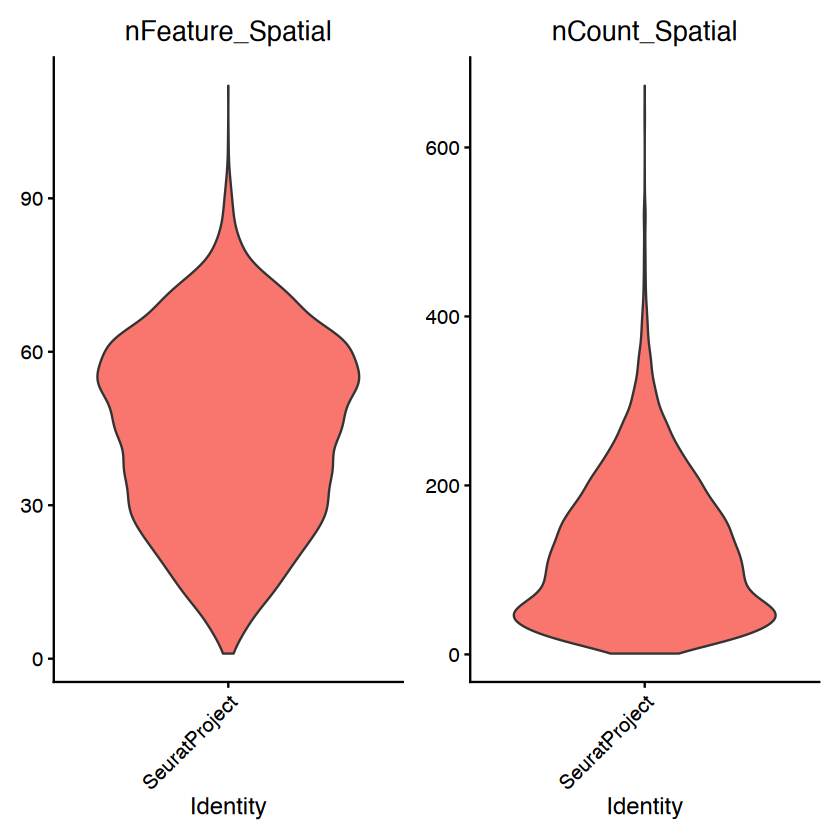

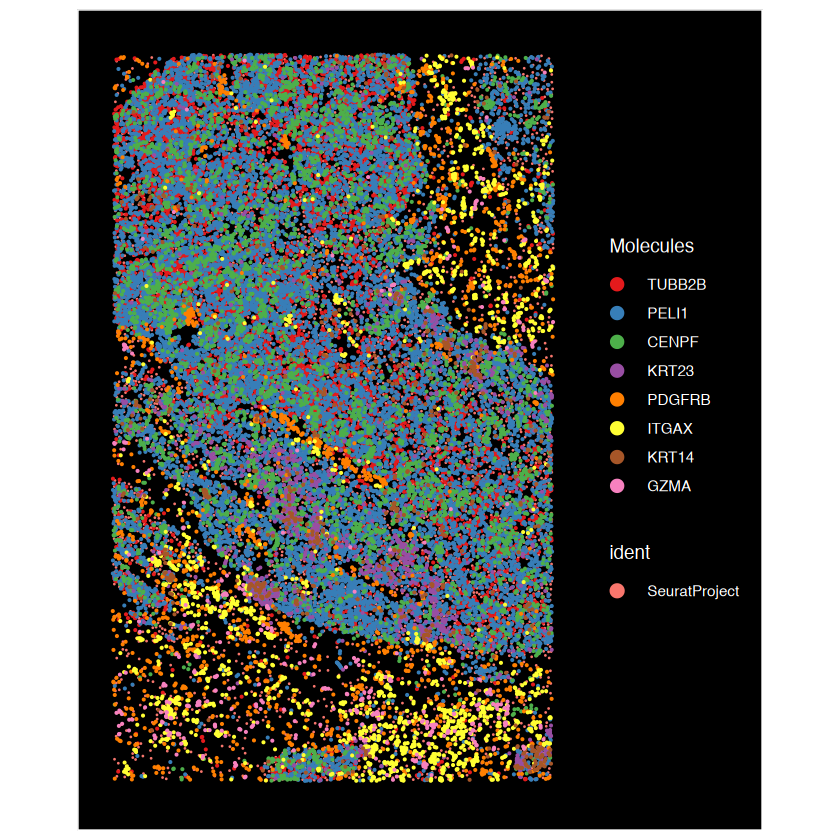

In [4]:

xenium.obj <- subset(xenium.obj, subset = nCount_Spatial > 0)

print(dim(xenium.obj@assays$Spatial$counts))
xenium.obj@assays$Spatial$counts[1:5,1:5]
head(xenium.obj@meta.data)
summary(xenium.obj@meta.data$nCount_Spatial)
summary(xenium.obj@meta.data$nFeature_Spatial)

VlnPlot(xenium.obj, features = c("nFeature_Spatial", "nCount_Spatial"), ncol = 2, pt.size = 0)

ImageDimPlot(xenium.obj, fov = "fov", molecules = c("TUBB2B", "PELI1", "CENPF", "KRT23","PDGFRB","ITGAX","KRT14","GZMA"), nmols = 20000)

In [ ]:

xenium.obj <- SCTransform(xenium.obj, assay = "Spatial",
                          conserve.memory = TRUE, vst.flavor="v2")
xenium.obj <- RunPCA(xenium.obj, assay = "SCT", verbose = FALSE)
xenium.obj <- FindNeighbors(xenium.obj, 
                     reduction = "pca", 
                     k.param = 30,
                     dims = 1:30)
xenium.obj <- RunUMAP(xenium.obj, 
               reduction = "pca", 
               n.neighbors = 30L,
               min.dist = 0.3,
               dims = 1:30)

print("Clustering...")
snn_pcs <- BuildSNNSeurat(xenium.obj[["pca"]]@cell.embeddings[,1:30], 
                          nn.eps = 0)

resolution_list <- c(0.2, 0.4, 0.6, 0.8, 1.0)
ids_cos <- Reduce(cbind, parallel::mclapply(resolution_list, function(res_use) {
  Seurat:::RunModularityClustering(SNN = snn_pcs, 
                                   modularity = 1, 
                                   resolution = res_use, 
                                   algorithm = 3, 
                                   n.start = 10, 
                                   n.iter = 10, random.seed = 0, print.output = FALSE, 
                                   temp.file.location = NULL, edge.file.name = NULL)    
}, mc.cores = min(16, length(resolution_list))))
ids_cos %<>% data.frame()
colnames(ids_cos) <- sprintf("res_%.2f", resolution_list)

ids_cos$res_0.20 <- as.character(ids_cos$res_0.20)
ids_cos$res_0.40 <- as.character(ids_cos$res_0.40)
ids_cos$res_0.60 <- as.character(ids_cos$res_0.60)
ids_cos$res_0.80 <- as.character(ids_cos$res_0.80)
ids_cos$res_1.00 <- as.character(ids_cos$res_1.00)

rownames(ids_cos) = rownames(xenium.obj@meta.data)
ids_cos <- ids_cos %>%
  dplyr::mutate(across(everything(), ~ factor(.x, levels = sort(unique(.x)))))
xenium.obj <- AddMetaData(xenium.obj, ids_cos)
head(xenium.obj@meta.data)


resolution = "0.60"
Idents(xenium.obj) = xenium.obj@meta.data[,paste0("res_",resolution)]

cluster_col = paste0("res_",resolution)

Running SCTransform on assay: Spatial

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 280 by 7273

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 268 genes, 5000 cells

Found 12 outliers - those will be ignored in fitting/regularization step


Skip calculation of full residual matrix

Will not return corrected UMI because residual type is not set to 'pearson'

Calculating gene attributes

Wall clock passed: Time difference of 0.9468322 secs

Setting min_variance based on median UMI:  0.04

Calculating variance for residuals of type pearson for 280 genes

Determine variable features

Setting min_variance based on median UMI:  0.04

Calculating residuals of type pearson for 280 genes



  |======================================================================| 100%


Computing corrected UMI count matrix

Centering data matrix

Getting residuals for block 1(of 2) for counts dataset

Getting residuals for block 2(of 2) for counts dataset

Centering data matrix

Finished calculating residuals for counts

Set default assay to SCT

Computing nearest neighbor graph

Computing SNN

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
21:09:36 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

21:09:36 Read 7273 rows and found 30 numeric columns

21:09:36 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'


[1] "Clustering..."


orig.ident    nCount_Spatial nFeature_Spatial nCount_BlankCodeword
aaaiikim-1 SeuratProject  66            32               0                   
aaaljapa-1 SeuratProject  95            43               0                   
aabhbgmg-1 SeuratProject 215            74               0                   
aabpgobe-1 SeuratProject 103            42               0                   
aacemgol-1 SeuratProject  95            49               0                   
aacnljfi-1 SeuratProject 146            56               0                   
           nFeature_BlankCodeword nCount_ControlCodeword
aaaiikim-1 0                      0                     
aaaljapa-1 0                      0                     
aabhbgmg-1 0                      0                     
aabpgobe-1 0                      0                     
aacemgol-1 0                      0                     
aacnljfi-1 0                      0                     
           nFeature_ControlCodeword nCount_ControlProbe nFeature_ControlProbe
aaaiikim-1 0                        0                   0                    
aaaljapa-1 0                        0                   0                    
aabhbgmg-1 0                        0                   0                    
aabpgobe-1 0                        0                   0                    
aacemgol-1 0                        0                   0                    
aacnljfi-1 0                        0                   0                    
           nCount_SCT nFeature_SCT res_0.20 res_0.40 res_0.60 res_0.80 res_1.00
aaaiikim-1 112        33           0        2        2        2        1       
aaaljapa-1 107        43           0        2        0        2        1       
aabhbgmg-1 139        69           0        3        3        3        1       
aabpgobe-1 111        42           0        0        0        2        1       
aacemgol-1 106        49           0        3        3        3        3       
aacnljfi-1 132        56           0        0        0        2        1

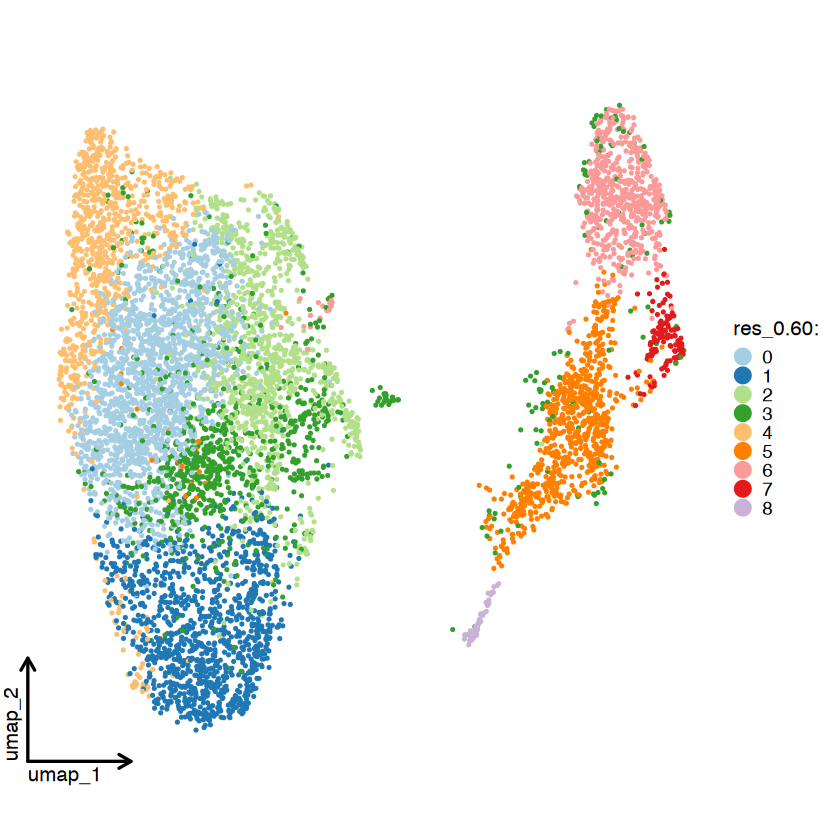

In [6]:
g = CellDimPlot(
  srt = xenium.obj, 
  group.by = cluster_col, 
  reduction = "UMAP", theme_use = "theme_blank",
  raster = FALSE,
  stat_plot_size = 3
) 
g 

In [7]:
xenium.obj.markers <- FindAllMarkers(xenium.obj, only.pos = TRUE)
xenium.obj.markers %>%
  group_by(cluster) %>%
  dplyr::slice_max(avg_log2FC, n = 10) %>%
  as.data.frame() 

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1   2.662899e-144 1.1679022  0.672 0.333 7.456118e-142 0       TUBB2B  
2    9.566100e-58 1.1014546  0.297 0.131  2.678508e-55 0       CAV1    
3    4.131144e-47 1.0423056  0.288 0.138  1.156720e-44 0       MYBPC1  
4    1.174734e-09 0.9748890  0.065 0.032  3.289254e-07 0       SERHL2  
5    5.652455e-83 0.8908141  0.614 0.365  1.582687e-80 0       SLC5A6  
6   5.093635e-147 0.8779398  0.862 0.585 1.426218e-144 0       CCND1   
7    4.594085e-54 0.8503573  0.450 0.255  1.286344e-51 0       TRAF4   
8    6.618904e-26 0.8189392  0.236 0.131  1.853293e-23 0       PTRHD1  
9   1.403824e-215 0.7650828  0.999 0.890 3.930707e-213 0       AQP1    
10   7.102044e-03 0.7501358  0.020 0.011  1.000000e+00 0       APOBEC3A
11   0.000000e+00 3.0765049  0.955 0.291  0.000000e+00 1       TOP2A   
12   0.000000e+00 2.7393502  0.719 0.176  0.000000e+00 1       CENPF   
13   0.000000e+00 2.6929152  0.877 0.266  0.000000e+00 1       MKI67   
14  1.834973e-179 2.1395594  0.475 0.126 5.137924e-177 1       RTKN2   
15  6.780687e-134 1.9392679  0.412 0.119 1.898592e-131 1       PCLAF   
16   3.384295e-47 0.8499877  0.593 0.385  9.476026e-45 1       TUBB2B  
17   3.258181e-13 0.7497524  0.185 0.108  9.122906e-11 1       FOXC2   
18   3.059700e-07 0.6872314  0.102 0.060  8.567159e-05 1       TCF7    
19   6.658867e-33 0.6227176  0.644 0.466  1.864483e-30 1       EIF4EBP1
20   9.353109e-12 0.6102920  0.273 0.186  2.618870e-09 1       ANKRD28 
21  3.338556e-168 3.2232114  0.284 0.042 9.347957e-166 2       KRT23   
22   1.182827e-14 3.1600350  0.029 0.005  3.311916e-12 2       KRT5    
23   2.419718e-54 2.4714986  0.144 0.033  6.775211e-52 2       KRT14   
24  1.462371e-127 2.3292966  0.301 0.064 4.094640e-125 2       KLF5    
25   5.715703e-55 2.2236511  0.139 0.030  1.600397e-52 2       MLPH    
26   1.373781e-11 2.2141908  0.037 0.010  3.846588e-09 2       S100A14 
27  7.226854e-177 1.7475072  0.706 0.299 2.023519e-174 2       KIT     
28   2.408642e-15 1.7219561  0.071 0.025  6.744196e-13 2       MUC6    
29   2.346541e-20 1.7013104  0.102 0.037  6.570315e-18 2       CLIC6   
30  6.904015e-144 1.6591053  0.666 0.306 1.933124e-141 2       CXCR4   
... ...           ...        ...   ...   ...           ...     ...     
56   0.000000e+00 5.507074   0.646 0.030  0.000000e+00 6       ITGAX   
57  2.314770e-296 5.191223   0.293 0.011 6.481356e-294 6       ITGAM   
58   0.000000e+00 4.997259   0.559 0.031  0.000000e+00 6       CD163   
59   0.000000e+00 4.884338   0.431 0.019  0.000000e+00 6       C1QA    
60   0.000000e+00 4.818968   0.887 0.121  0.000000e+00 6       LYZ     
61   0.000000e+00 4.620677   0.521 0.031  0.000000e+00 6       IGSF6   
62   0.000000e+00 4.610779   0.913 0.106  0.000000e+00 6       FCER1G  
63   0.000000e+00 4.573058   0.530 0.034  0.000000e+00 6       FCGR3A  
64   0.000000e+00 4.562829   0.833 0.096  0.000000e+00 6       CD68    
65   0.000000e+00 4.561834   0.480 0.028  0.000000e+00 6       C1QC    
66  3.031048e-133 6.841716   0.173 0.003 8.486933e-131 7       PRF1    
67   0.000000e+00 6.209282   0.835 0.029  0.000000e+00 7       CD3E    
68   0.000000e+00 6.203802   0.551 0.016  0.000000e+00 7       GZMA    
69   0.000000e+00 6.177333   0.764 0.025  0.000000e+00 7       TRAC    
70  3.158396e-292 6.129222   0.583 0.022 8.843508e-290 7       CCL5    
71  4.485128e-230 6.106686   0.354 0.009 1.255836e-227 7       CD247   
72   3.283038e-61 6.048701   0.079 0.001  9.192507e-59 7       GZMK    
73   9.214896e-60 6.023689   0.102 0.003  2.580171e-57 7       GNLY    
74  1.057008e-139 5.877429   0.244 0.007 2.959622e-137 7       CD69    
75  9.851276e-104 5.662232   0.189 0.006 2.758357e-101 7       NKG7    
76   0.000000e+00 7.763102   0.800 0.008  0.000000e+00 8       CLEC14A 
77   0.000000e+00 7.715937   0.900 0.016  0.000000e+00 8       VWF     
78   0.000000e+00 6.768240   0.686 0.012  0.000000e+00 8       KDR     
79   0.000000e+00 6.740594   0.629 0.011  0.

Cluster annotation:
0	Basal-like epithelial cells / Myoepithelial cells
1	Proliferating epithelial cells
2	Basal/myoepithelial tumor cells
3	Unclassified immune-like cells
4	Inflammatory immune cells (e.g. B cells / monocytes)
5	Cancer-associated fibroblasts (CAFs)
6	Macrophages (TAMs)
7	Cytotoxic / Activated T cells
8	Endothelial cells

In [8]:
table(xenium.obj@meta.data[,cluster_col])
xenium.obj@meta.data$new_cluster = dplyr::case_when(
  xenium.obj@meta.data[,cluster_col] == "0" ~ "BasalMyo_epithelial_cells",
  xenium.obj@meta.data[,cluster_col] == "1" ~ "Proliferating_epithelial_cells",
  xenium.obj@meta.data[,cluster_col] == "2" ~ "BasalMyo_tumor_cells",
  xenium.obj@meta.data[,cluster_col] == "3" ~ "Unclassified_immune-like_cells",
  xenium.obj@meta.data[,cluster_col] == "4" ~ "Inflammatory_immune_cells",
  xenium.obj@meta.data[,cluster_col] == "5" ~ "Cancer-associated_fibroblasts",
  xenium.obj@meta.data[,cluster_col] == "6" ~ "Tumor-associated_macrophages",
  xenium.obj@meta.data[,cluster_col] == "7" ~ "Cytotoxic_T",
  xenium.obj@meta.data[,cluster_col] == "8" ~ "Endothelial_cells"
)
table(xenium.obj@meta.data$new_cluster)
cluster_col = "new_cluster"
Idents(xenium.obj) = xenium.obj@meta.data$new_cluster


   0    1    2    3    4    5    6    7    8 
1794 1125 1060  906  827  754  610  127   70 


     BasalMyo_epithelial_cells           BasalMyo_tumor_cells 
                          1794                           1060 
 Cancer-associated_fibroblasts                    Cytotoxic_T 
                           754                            127 
             Endothelial_cells      Inflammatory_immune_cells 
                            70                            827 
Proliferating_epithelial_cells   Tumor-associated_macrophages 
                          1125                            610 
Unclassified_immune-like_cells 
                           906 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


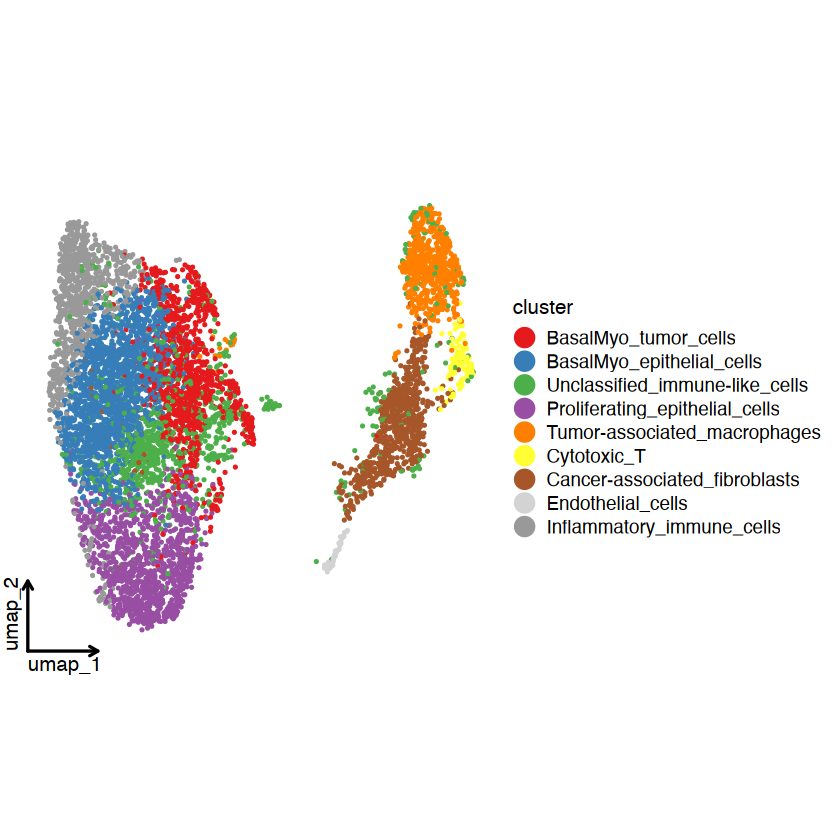

In [9]:
cluster_COLORS = manual_colors
names(cluster_COLORS) = levels(Idents(xenium.obj))
cluster_COLORS = na.omit(cluster_COLORS)
g = CellDimPlot(
  srt = xenium.obj, 
  group.by = cluster_col, 
  reduction = "UMAP", theme_use = "theme_blank",
  raster = FALSE,
  stat_plot_size = 1
) &
  scale_color_manual(values = cluster_COLORS) &
  guides(color = guide_legend(override.aes = list(size=5,
                                                 alpha = 1),
                             title = "cluster",
                             ncol = 1))
g 

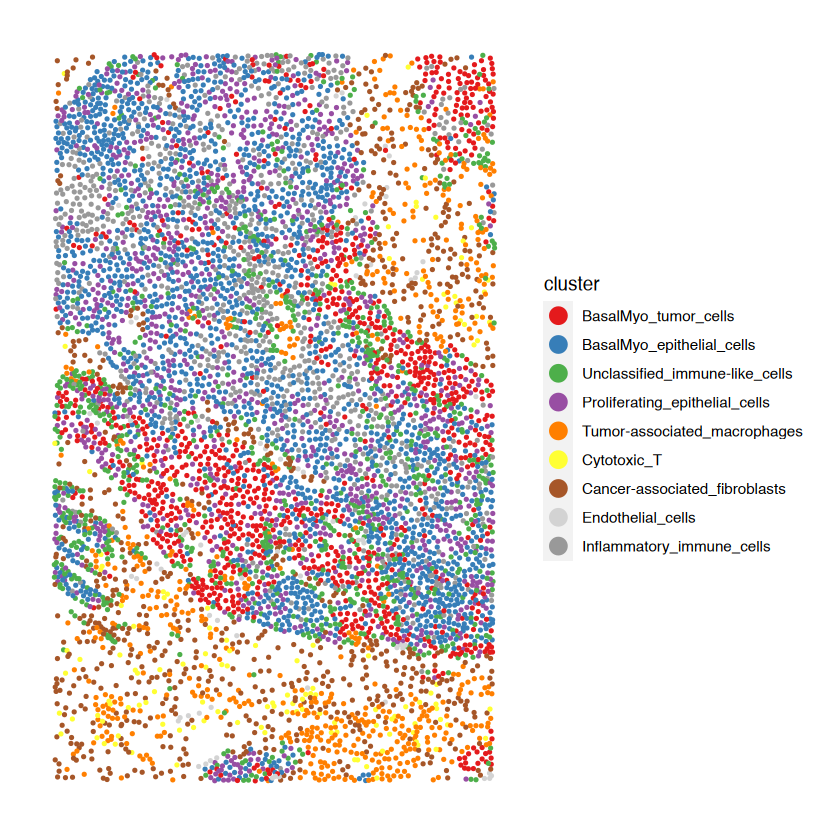

In [10]:
g = ImageDimPlot(xenium.obj,
             fov = "fov", 
             size = 1.2,
             group.by = cluster_col, 
             dark.background = F)  &
  scale_fill_manual(values = cluster_COLORS) &
  guides(fill = guide_legend(override.aes = list(size=5,
                                                 alpha = 1),
                             title = "cluster",
                             ncol = 1))
g 

## Spatial neighborhood analysis (SNA, cell type level analysis)

In [11]:
n_perm = 100
neighbors.k_ = 30 # Number of neighbors to search
seed = 1234

start_time = Sys.time()
xenium.obj <- nhood_enrichment.Seurat(
  xenium.obj,
  cluster_key = cluster_col, 
  neighbors.k = neighbors.k_, 
  connectivity_key = "nn", 
  transformation = TRUE,
  n_perms = n_perm, seed = seed, n_jobs = 4
)
end_time = Sys.time()
print("Elapsed time:")
difftime(end_time, start_time, units = "secs")

[1] "Elapsed time:"


Time difference of 7.601935 secs

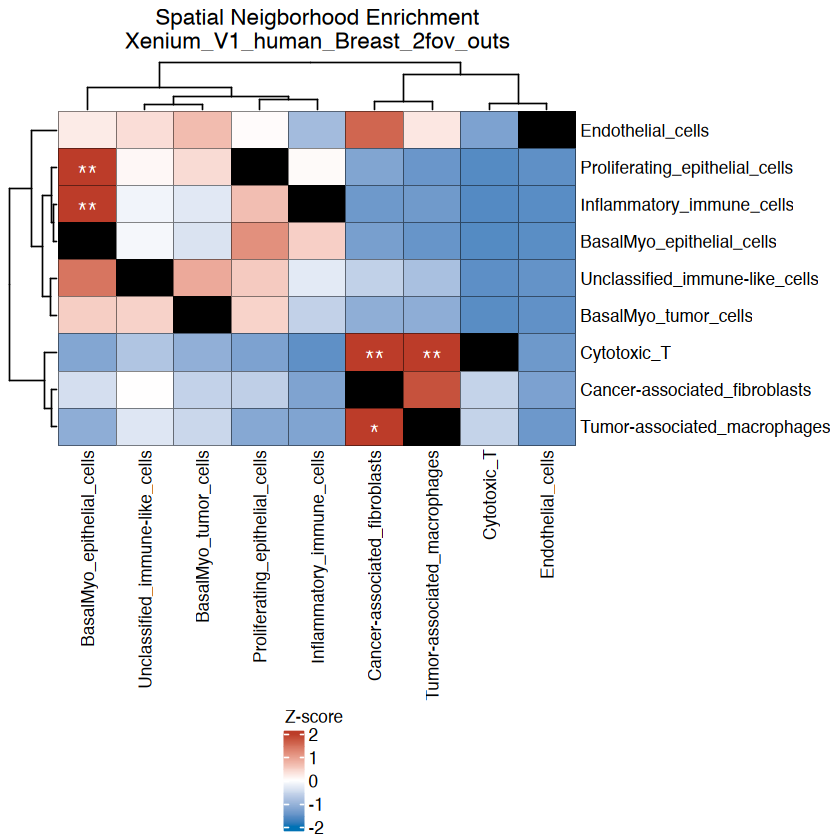

In [ ]:
mat = xenium.obj@misc[[paste0(cluster_col,"_nhood_enrichment")]]$zscore
colnames(mat) = gsub("^Cluster","",colnames(mat))
rownames(mat) = gsub("^Cluster","",rownames(mat))

pval_mat <- 1 - pnorm(mat)
fdr_vec <- p.adjust(as.vector(pval_mat), method = "BH")
fdr_mat <- matrix(fdr_vec, nrow=nrow(mat), ncol=ncol(mat),
                  dimnames = dimnames(mat))
sig_mat <- ifelse(fdr_mat < 0.05, "**", ifelse(fdr_mat > 0.05 & fdr_mat < 0.1, "*", ""))

common_names <- intersect(rownames(mat), colnames(mat))
for (nm in common_names) {
  mat[nm, nm] <- NA
  sig_mat[nm, nm] <- ""
}

heatmap <- Heatmap(mat,
                   name = "Z-score",
                   col = colorRamp2(c(-2, 0, 2), c("#0072B5FF", "white", "#BC3C29FF")), 
                   show_row_names = TRUE, 
                   show_column_names = TRUE,  
                   cluster_rows = TRUE,  
                   cluster_columns = TRUE,  
                   #show_column_dend = FALSE,
                   #show_row_dend = FALSE,
                   row_title = "",  
                   column_title = paste0("Spatial Neigborhood Enrichment\n",data_name),
                   rect_gp = gpar(col = "black", lwd = 0.3),
                   na_col = "black",         
                   column_names_gp = grid::gpar(fontsize = 10),
                   row_names_gp = grid::gpar(fontsize = 10),

                   cell_fun = function(j, i, x, y, width, height, fill) {
                     if(sig_mat[i, j] == "**") {
                       grid.text("**", 
                                 x = x,
                                 y = y - 0.2 * height,  
                                 gp = gpar(fontsize = 15, col = "white", fontface = "bold"))
                     }
                     if(sig_mat[i, j] == "*") {
                       grid.text("*", 
                                 x = x,
                                 y = y - 0.2 * height, 
                                 gp = gpar(fontsize = 15, col = "white", fontface = "bold"))
                     }
                   }
)


draw(heatmap, 
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")


## Spatial co-localization score (sCLA, cell-cell level analysis)

In [13]:
xenium.obj[["fov"]]$centroids@coords

x          y        
 [1,]   3.986221 342.61966
 [2,]   6.680080 353.63556
 [3,]  10.924507 344.44751
 [4,]  12.469139 326.37842
 [5,]  13.614200 336.31012
 [6,]  16.602362 292.55316
 [7,]  18.095470 307.78577
 [8,]   7.015532 306.04666
 [9,]  13.646845 299.77997
[10,]  18.019503 317.56729
[11,]   4.900125 323.01886
[12,]   9.570869 315.95383
[13,]  33.660454 169.15588
[14,] 118.657547  87.02421
[15,] 127.557861 128.69392
[16,] 195.570312 259.40088
[17,] 185.530029 144.04372
[18,] 146.584167 251.46104
[19,] 132.430725  92.89492
[20,] 123.896126  77.43526
[21,] 185.468582  22.79720
[22,] 129.620270  85.98190
[23,]  35.328915 293.49655
[24,]  31.849537 307.49612
[25,]  38.008217 302.40729
[26,]  26.706833 299.92395
[27,]  52.746372 304.86227
[28,]  44.550003 317.14578
[29,]  43.461903 308.18326
[30,]  45.321529 296.22226
[31,] ...        ...      
[32,]  386.5923  249.85770
[33,]  365.6164  268.12885
[34,]  665.3920  538.91150
[35,]  626.8651  523.63293
[36,]  820.7482  151.86137
[37,]  830.9116  132.43082
[38,]  803.0009  328.66089
[39,]  596.5007   72.90670
[40,] 1066.7518  562.16168
[41,]  913.9797  339.93573
[42,] 1050.9253  379.66013
[43,] 1032.1899  431.91525
[44,]  889.4853   37.63133
[45,]  957.7563  111.30595
[46,] 1199.3645  687.77332
[47,] 1052.4490  153.09167
[48,] 1000.3040  116.55745
[49,] 1097.8085  355.41992
[50,] 1139.2590  105.91132
[51,]  824.4532  730.56311
[52,]  851.0555  730.78180
[53,]  827.7892  628.86633
[54,]  703.7122  584.78668
[55,]  699.8170  591.30750
[56,]  623.7773  613.40106
[57,]  736.5967  400.61972
[58,]  748.6306  400.94659
[59,]  780.6490  621.38281
[60,]  775.7633  745.26538
[61,]  717.4011  406.35110

In [14]:

cluster_x <- "Cytotoxic_T"
cluster_y <- "Cancer-associated_fibroblasts"
table(Idents(xenium.obj))
radius_ = 30 # Radius to search for neighbors (µm, cell_type_2) around anchor cells (cell_type_1)

start_time = Sys.time()
cooccur_local_df <- cooccur_local.Seurat(
  xenium.obj,
  cluster_key      = cluster_col,
  sample_key       = "fov",
  cluster_x        = cluster_x,
  cluster_y        = cluster_y,
  connectivity_key = "nn",
  neighbors.k      = neighbors.k_, 
  radius           = radius_,
  maxnsteps        = 15
)
end_time = Sys.time()
print("Elapsed time:")
difftime(end_time, start_time, units = "secs")
summary(cooccur_local_df)


          BasalMyo_tumor_cells      BasalMyo_epithelial_cells 
                          1060                           1794 
Unclassified_immune-like_cells Proliferating_epithelial_cells 
                           906                           1125 
  Tumor-associated_macrophages                    Cytotoxic_T 
                           610                            127 
 Cancer-associated_fibroblasts              Endothelial_cells 
                           754                             70 
     Inflammatory_immune_cells 
                           827 

stopping after 4 steps



[1] "Elapsed time:"


Time difference of 1.524861 secs

 cooccur_local_Cytotoxic_T_Cancer-associated_fibroblasts
 Min.   :0.00000                                        
 1st Qu.:0.00000                                        
 Median :0.00000                                        
 Mean   :0.11811                                        
 3rd Qu.:0.03125                                        
 Max.   :1.13205                                        

Warning message:
"No FOV associated with assay 'SCT', using global default FOV"


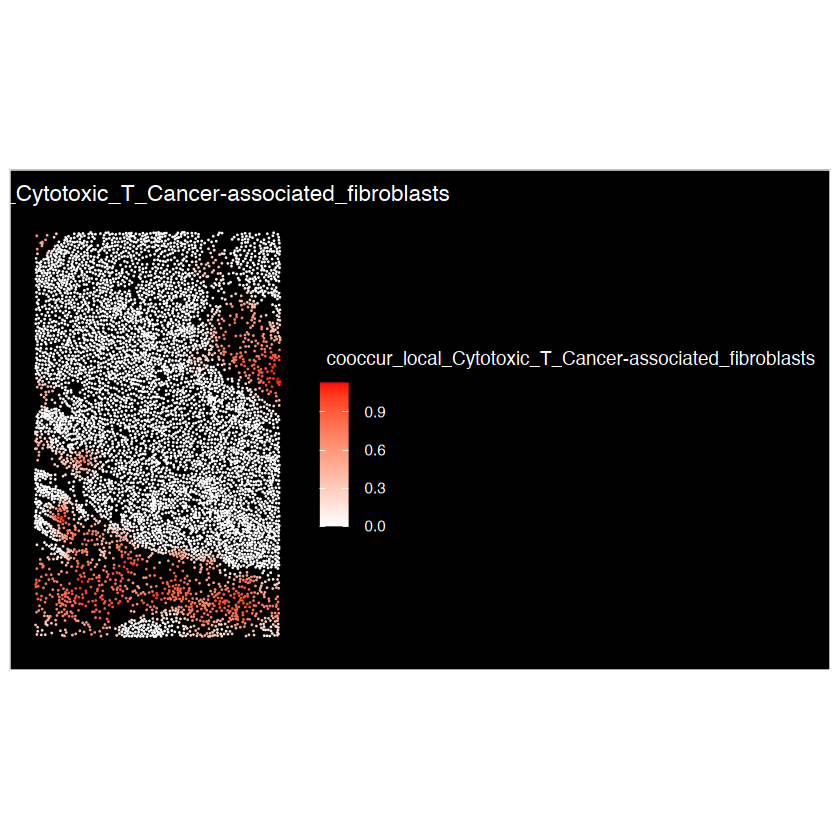

In [15]:
xenium.obj = AddMetaData(xenium.obj, cooccur_local_df)

g = ImageFeaturePlot(xenium.obj, 
                     features = paste0("cooccur_local_",cluster_x,"_",cluster_y), 
                     #dark.background = F,
                     cols = c("white", "red"))
g

# Xenium Mouse Brain

## Preprocessing & Cell annotation

10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warn

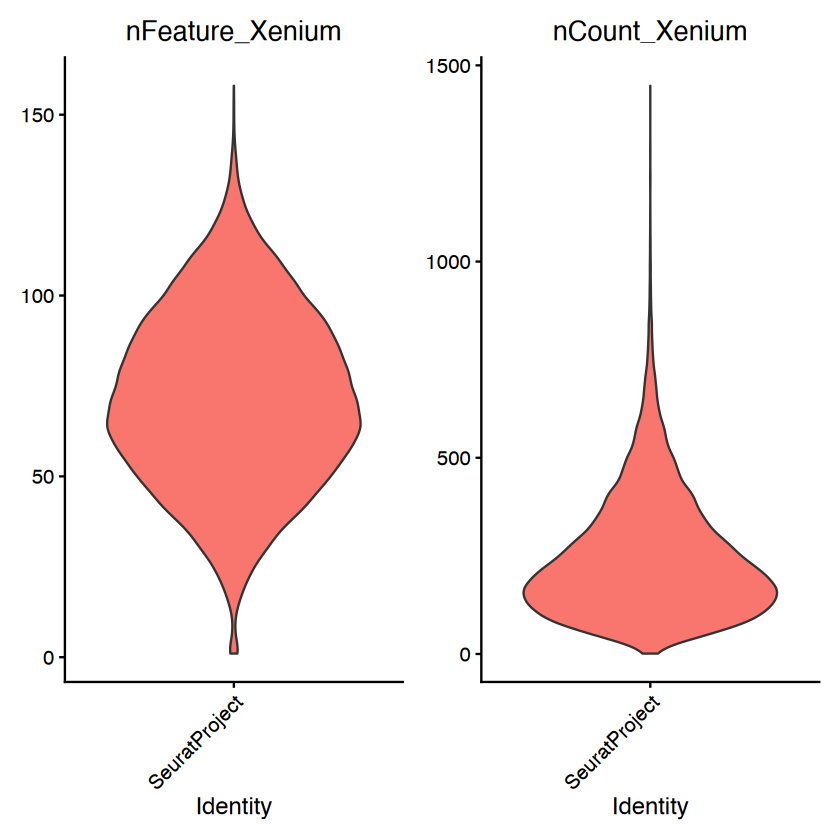

In [ ]:
path <- "/path/to/10X_Xenium_sample/Xenium_V1_FF_Mouse_Brain_Coronal_Subset_CTX_HP_outs/"
data_name = stringr::str_split(path, "/")[[1]][length(stringr::str_split(path, "/")[[1]])-1]

xenium.obj <- LoadXenium(path, fov = "fov")
# remove cells with 0 counts
xenium.obj <- subset(xenium.obj, subset = nCount_Xenium > 0)

VlnPlot(xenium.obj, features = c("nFeature_Xenium", "nCount_Xenium"), ncol = 2, pt.size = 0)

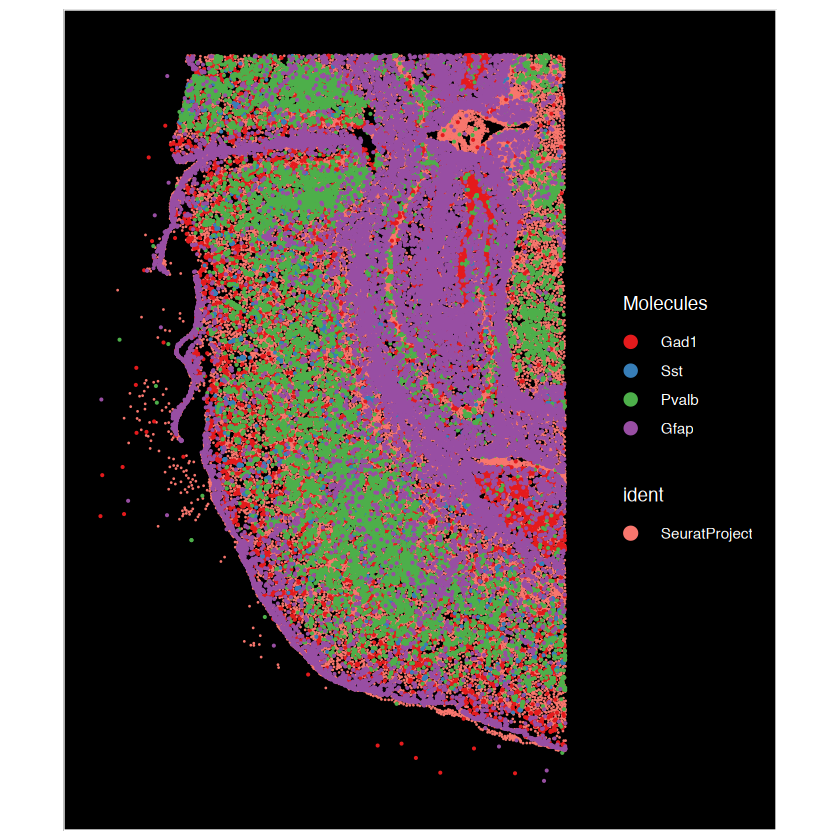

In [17]:
ImageDimPlot(xenium.obj, 
             fov = "fov", 
             size = 0.5,
             molecules = c("Gad1", "Sst", "Pvalb", "Gfap"), nmols = 20000)

In [18]:
xenium.obj <- SCTransform(xenium.obj, assay = "Xenium")
xenium.obj <- RunPCA(xenium.obj, npcs = 30, features = rownames(xenium.obj))
xenium.obj <- RunUMAP(xenium.obj, dims = 1:30)
xenium.obj <- FindNeighbors(xenium.obj, reduction = "pca", dims = 1:30)
xenium.obj <- FindClusters(xenium.obj, resolution = 0.3)

Running SCTransform on assay: Xenium

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 248 by 36553

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 248 genes, 5000 cells

Second step: Get residuals using fitted parameters for 248 genes

Computing corrected count matrix for 248 genes

Calculating gene attributes

Wall clock passed: Time difference of 1.505853 secs

Determine variable features

Centering data matrix

Getting residuals for block 1(of 8) for counts dataset

Getting residuals for block 2(of 8) for counts dataset

Getting residuals for block 3(of 8) for counts dataset

Getting residuals for block 4(of 8) for counts dataset

Getting residuals for block 5(of 8) for counts dataset

Getting residuals for block 6(of 8) for counts dataset

Getting residuals for block 7(of 8) for counts dataset

Getting residuals

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36553
Number of edges: 1341724

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9586
Number of communities: 29
Elapsed time: 3 seconds


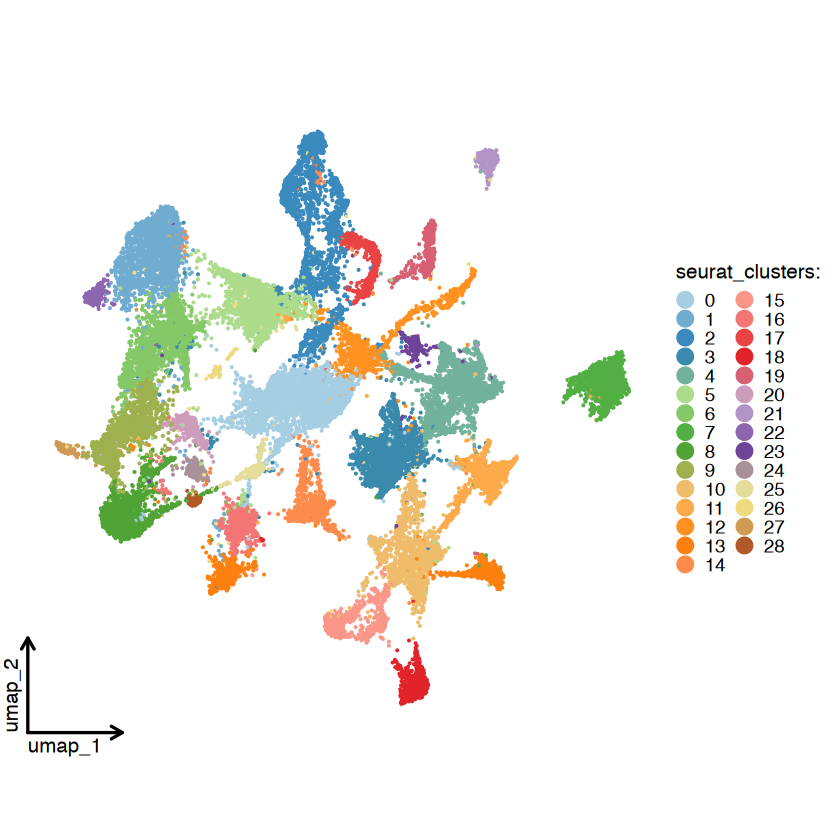

In [19]:

cluster_col="seurat_clusters"
g = CellDimPlot(
  srt = xenium.obj, 
  group.by = cluster_col, 
  reduction = "UMAP", theme_use = "theme_blank",
  raster = FALSE,
  stat_plot_size = 3
) 
g 


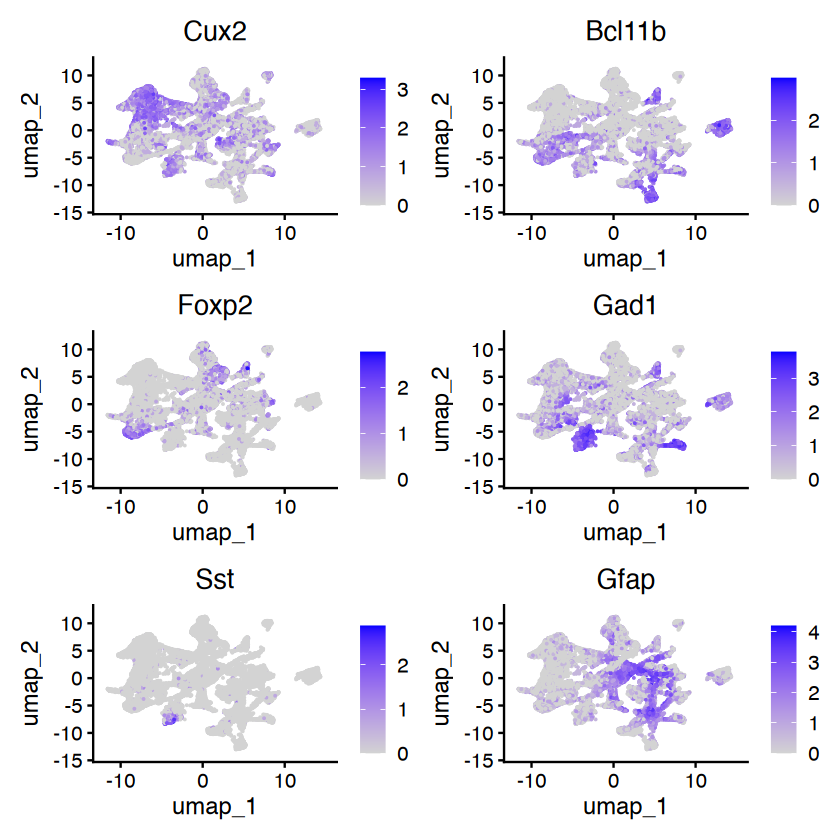

In [20]:
FeaturePlot(xenium.obj, features = c("Cux2", "Bcl11b", "Foxp2", "Gad1", "Sst", "Gfap"))

Warning message:
"No FOV associated with assay 'SCT', using global default FOV"


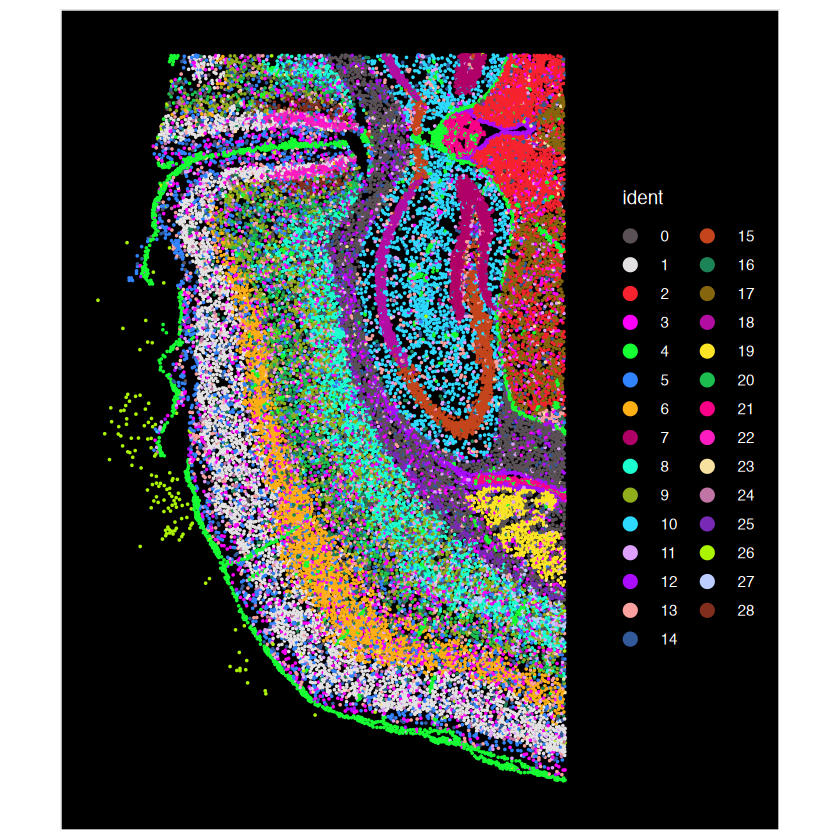

In [21]:
ImageDimPlot(xenium.obj, cols = "polychrome", 
             size = 0.75)

In [22]:
library(spacexr)

query.counts <- GetAssayData(xenium.obj, assay = "Xenium", slot = "counts")
coords <- GetTissueCoordinates(xenium.obj[["fov"]], which = "centroids")
rownames(coords) <- coords$cell
coords$cell <- NULL
query <- SpatialRNA(coords, query.counts, colSums(query.counts))

Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
i Please use the `layer` argument instead."


In [ ]:
# allen.corted.ref can be downloaded here:
# https://www.dropbox.com/s/cuowvm4vrf65pvq/allen_cortex.rds?dl=1
allen.cortex.ref <- readRDS("/path/to/10X_Xenium_sample/allen_cortex.rds")
allen.cortex.ref <- UpdateSeuratObject(allen.cortex.ref)

Idents(allen.cortex.ref) <- "subclass"
# remove CR cells because there aren't enough of them for annotation
allen.cortex.ref <- subset(allen.cortex.ref, subset = subclass != "CR")
counts <- GetAssayData(allen.cortex.ref, assay = "RNA", slot = "counts")
cluster <- as.factor(allen.cortex.ref$subclass)
names(cluster) <- colnames(allen.cortex.ref)
nUMI <- allen.cortex.ref$nCount_RNA
names(nUMI) <- colnames(allen.cortex.ref)
nUMI <- colSums(counts)
levels(cluster) <- gsub("/", "-", levels(cluster))
reference <- Reference(counts, cluster, nUMI)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Warning message:
"Assay RNA changing from Assay to Assay"
Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Validating object structure for Assay 'RNA'

Object representation is consistent with the most current Seurat version



In [24]:
# run RCTD with many cores
RCTD <- create.RCTD(query, reference, max_cores = 8)
RCTD <- run.RCTD(RCTD, doublet_mode = "doublet")

Begin: process_cell_type_info

process_cell_type_info: number of cells in reference: 14242

process_cell_type_info: number of genes in reference: 34617




     Astro       Endo    L2-3 IT         L4      L5 IT      L5 PT      L6 CT 
       368         94        982       1401        880        544        960 
     L6 IT        L6b      Lamp5 Macrophage      Meis2         NP      Oligo 
      1872        358       1122         51         45        362         91 
      Peri      Pvalb        SMC   Serpinf1       Sncg        Sst       VLMC 
        32       1337         55         27        125       1741         67 
       Vip 
      1728 


End: process_cell_type_info

create.RCTD: getting regression differentially expressed genes: 

get_de_genes: Astro found DE genes: 9

get_de_genes: Endo found DE genes: 15

get_de_genes: L2-3 IT found DE genes: 7

get_de_genes: L4 found DE genes: 13

get_de_genes: L5 IT found DE genes: 8

get_de_genes: L5 PT found DE genes: 4

get_de_genes: L6 CT found DE genes: 11

get_de_genes: L6 IT found DE genes: 8

get_de_genes: L6b found DE genes: 11

get_de_genes: Lamp5 found DE genes: 9

get_de_genes: Macrophage found DE genes: 11

get_de_genes: Meis2 found DE genes: 12

get_de_genes: NP found DE genes: 10

get_de_genes: Oligo found DE genes: 7

get_de_genes: Peri found DE genes: 10

get_de_genes: Pvalb found DE genes: 7

get_de_genes: SMC found DE genes: 13

get_de_genes: Serpinf1 found DE genes: 9

get_de_genes: Sncg found DE genes: 12

get_de_genes: Sst found DE genes: 10

get_de_genes: VLMC found DE genes: 13

get_de_genes: Vip found DE genes: 10

get_de_genes: total DE genes: 122

create.

[1] "gather_results: finished 1000"
[1] "gather_results: finished 2000"
[1] "gather_results: finished 3000"
[1] "gather_results: finished 4000"
[1] "gather_results: finished 5000"
[1] "gather_results: finished 6000"
[1] "gather_results: finished 7000"
[1] "gather_results: finished 8000"
[1] "gather_results: finished 9000"
[1] "gather_results: finished 10000"
[1] "gather_results: finished 11000"
[1] "gather_results: finished 12000"
[1] "gather_results: finished 13000"
[1] "gather_results: finished 14000"
[1] "gather_results: finished 15000"
[1] "gather_results: finished 16000"
[1] "gather_results: finished 17000"
[1] "gather_results: finished 18000"
[1] "gather_results: finished 19000"
[1] "gather_results: finished 20000"
[1] "gather_results: finished 21000"
[1] "gather_results: finished 22000"
[1] "gather_results: finished 23000"
[1] "gather_results: finished 24000"
[1] "gather_results: finished 25000"
[1] "gather_results: finished 26000"
[1] "gather_results: finished 27000"
[1] "gathe

In [25]:
annotations.df <- RCTD@results$results_df
annotations <- annotations.df$first_type
names(annotations) <- rownames(annotations.df)
xenium.obj$predicted.celltype <- annotations
keep.cells <- Cells(xenium.obj)[!is.na(xenium.obj$predicted.celltype)]
xenium.obj <- subset(xenium.obj, cells = keep.cells)

Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Seurat objects"


In [26]:
cluster_col="predicted.celltype"
Idents(xenium.obj) = xenium.obj@meta.data[,cluster_col]

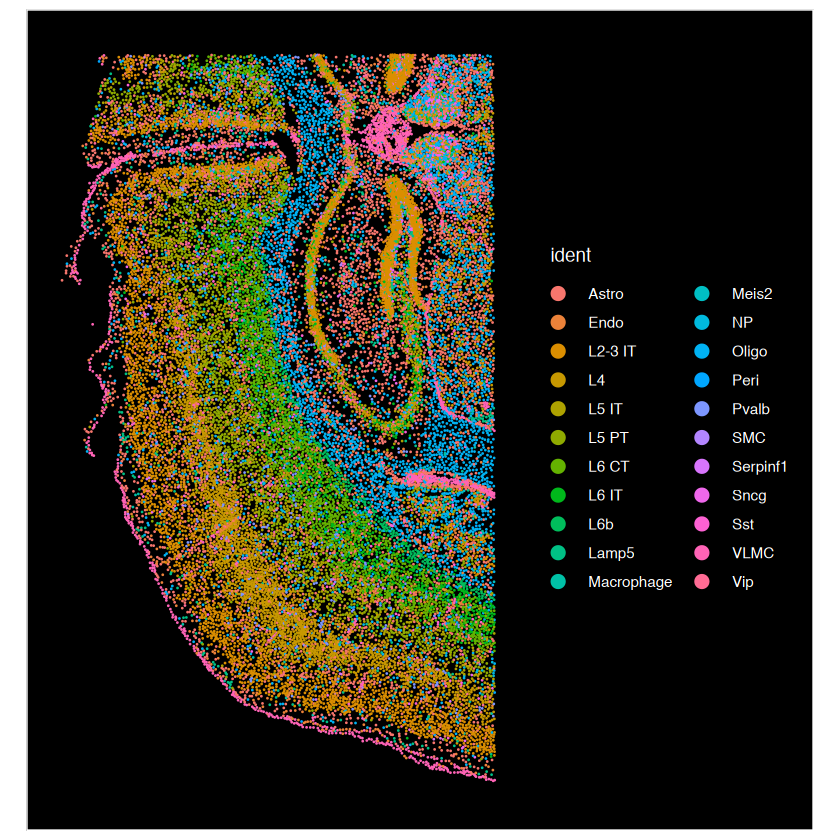

In [27]:
markers = xenium.obj.markers %>%
  group_by(cluster) %>%
  dplyr::slice_max(avg_log2FC, n = 1) %>%
  as.data.frame() %>%
  pull(gene) %>%
  unique()
marker_COLORS = manual_colors
names(marker_COLORS) = markers
  
ImageDimPlot(xenium.obj, fov = "fov", molecules = markers, nmols = 20000) &
  scale_color_manual(values = marker_COLORS) 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


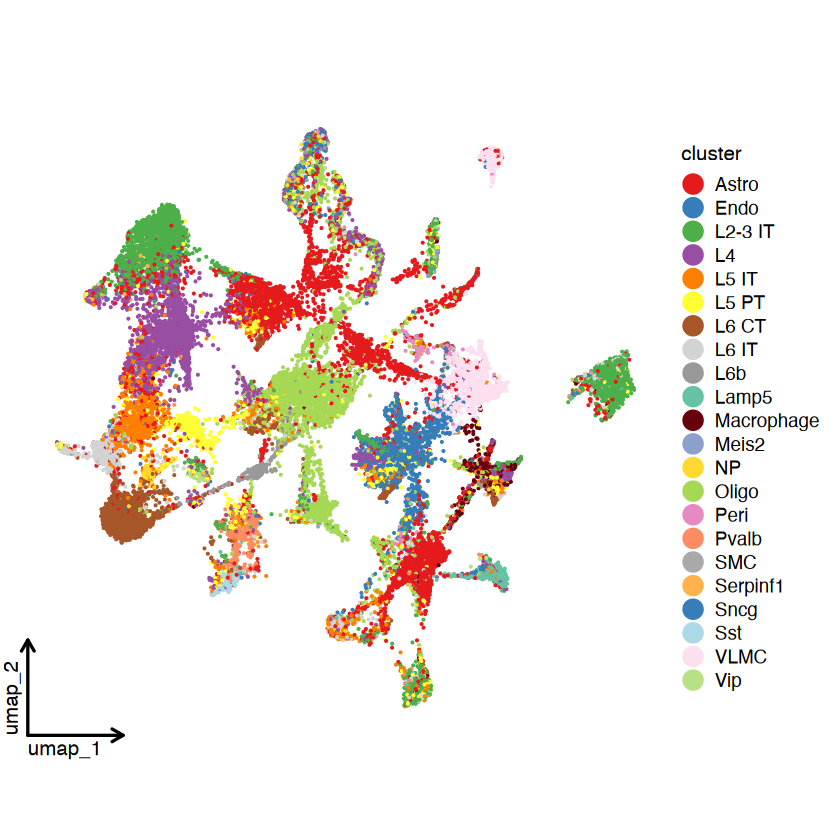

In [28]:

cluster_COLORS = manual_colors
names(cluster_COLORS) = levels(Idents(xenium.obj))
cluster_COLORS = na.omit(cluster_COLORS)
g = CellDimPlot(
  srt = xenium.obj, 
  group.by = cluster_col, 
  reduction = "UMAP", theme_use = "theme_blank",
  raster = FALSE,
  stat_plot_size = 1
) &
  scale_color_manual(values = cluster_COLORS) &
  guides(color = guide_legend(override.aes = list(size=5,
                                                 alpha = 1),
                             title = "cluster",
                             ncol = 1))
g 

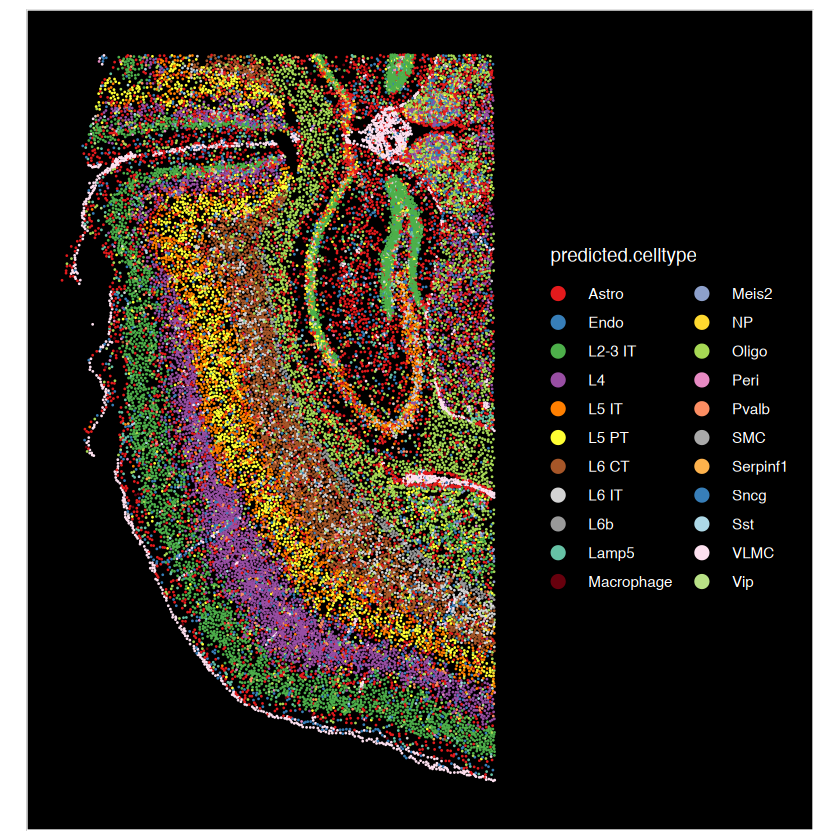

In [29]:
g = ImageDimPlot(xenium.obj,
             fov = "fov", 
             size = 0.5,
             group.by = cluster_col)  &
  scale_fill_manual(values = cluster_COLORS)
g 

## Spatial neighborhood analysis (SNA, cell type level analysis)

In [30]:
n_perm = 100
neighbors.k_ = 30 # Number of neighbors to search
seed = 1234

start_time = Sys.time()
xenium.obj <- nhood_enrichment.Seurat(
  xenium.obj,
  cluster_key = cluster_col, 
  neighbors.k = neighbors.k_, 
  connectivity_key = "nn", 
  transformation = TRUE,
  n_perms = n_perm, seed = seed, n_jobs = 4
)
end_time = Sys.time()
print("Elapsed time:")
difftime(end_time, start_time, units = "secs")

[1] "Elapsed time:"


Time difference of 31.67092 secs

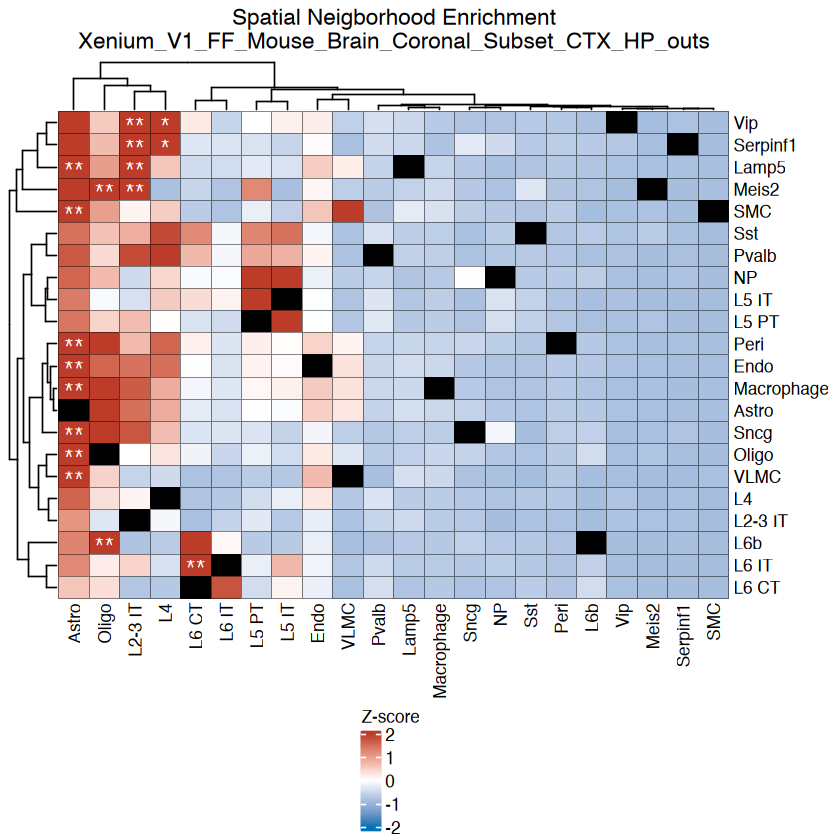

In [ ]:
mat = xenium.obj@misc[[paste0(cluster_col,"_nhood_enrichment")]]$zscore
colnames(mat) = gsub("^Cluster","",colnames(mat))
rownames(mat) = gsub("^Cluster","",rownames(mat))

pval_mat <- 1 - pnorm(mat)
fdr_vec <- p.adjust(as.vector(pval_mat), method = "BH")
fdr_mat <- matrix(fdr_vec, nrow=nrow(mat), ncol=ncol(mat),
                  dimnames = dimnames(mat))
sig_mat <- ifelse(fdr_mat < 0.05, "**", ifelse(fdr_mat > 0.05 & fdr_mat < 0.1, "*", ""))

common_names <- intersect(rownames(mat), colnames(mat))
for (nm in common_names) {
  mat[nm, nm] <- NA
  sig_mat[nm, nm] <- ""
}

heatmap <- Heatmap(mat,
                   name = "Z-score",
                   col = colorRamp2(c(-2, 0, 2), c("#0072B5FF", "white", "#BC3C29FF")), 
                   show_row_names = TRUE, 
                   show_column_names = TRUE,  
                   cluster_rows = TRUE,  
                   cluster_columns = TRUE,  
                   #show_column_dend = FALSE,
                   #show_row_dend = FALSE,
                   row_title = "",  
                   column_title = paste0("Spatial Neigborhood Enrichment\n",data_name),
                   rect_gp = gpar(col = "black", lwd = 0.3),
                   na_col = "black",          
                   column_names_gp = grid::gpar(fontsize = 10),
                   row_names_gp = grid::gpar(fontsize = 10),
                   cell_fun = function(j, i, x, y, width, height, fill) {
                     if(sig_mat[i, j] == "**") {
                       grid.text("**", 
                                 x = x,
                                 y = y - 0.2 * height,  
                                 gp = gpar(fontsize = 15, col = "white", fontface = "bold"))
                     }
                     if(sig_mat[i, j] == "*") {
                       grid.text("*", 
                                 x = x,
                                 y = y - 0.2 * height, 
                                 gp = gpar(fontsize = 15, col = "white", fontface = "bold"))
                     }
                   }
)

draw(heatmap, 
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")


## Spatial co-localization score (sCLA, cell-cell level analysis)

In [32]:

cluster_x <- "L6 IT"
cluster_y <- "L6 CT"
table(Idents(xenium.obj))
radius_ = 30 # Radius to search for neighbors (µm, cell_type_2) around anchor cells (cell_type_1)

start_time = Sys.time()
cooccur_local_df <- cooccur_local.Seurat(
  xenium.obj,
  cluster_key      = cluster_col,
  sample_key       = "fov",
  cluster_x        = cluster_x,
  cluster_y        = cluster_y,
  connectivity_key = "nn",
  neighbors.k      = neighbors.k_, 
  radius           = radius_,
  maxnsteps        = 15
)
end_time = Sys.time()
print("Elapsed time:")
difftime(end_time, start_time, units = "secs")


colnames(cooccur_local_df) = gsub(" ", "_", colnames(cooccur_local_df))
summary(cooccur_local_df)


     Astro       Endo    L2-3 IT         L4      L5 IT      L5 PT      L6 CT 
      5468       1773       4563       3679       1863       1896       2182 
     L6 IT        L6b      Lamp5 Macrophage      Meis2         NP      Oligo 
      1114        355        521        448         82        277       3892 
      Peri      Pvalb        SMC   Serpinf1       Sncg        Sst       VLMC 
       239        604         24         56        351        223       1417 
       Vip 
       114 

stopping after 4 steps



[1] "Elapsed time:"


Time difference of 6.685869 secs

 cooccur_local_L6_IT_L6_CT
 Min.   :0.0000           
 1st Qu.:0.0000           
 Median :0.0000           
 Mean   :0.0929           
 3rd Qu.:0.0000           
 Max.   :1.0787           

Warning message:
"No FOV associated with assay 'SCT', using global default FOV"


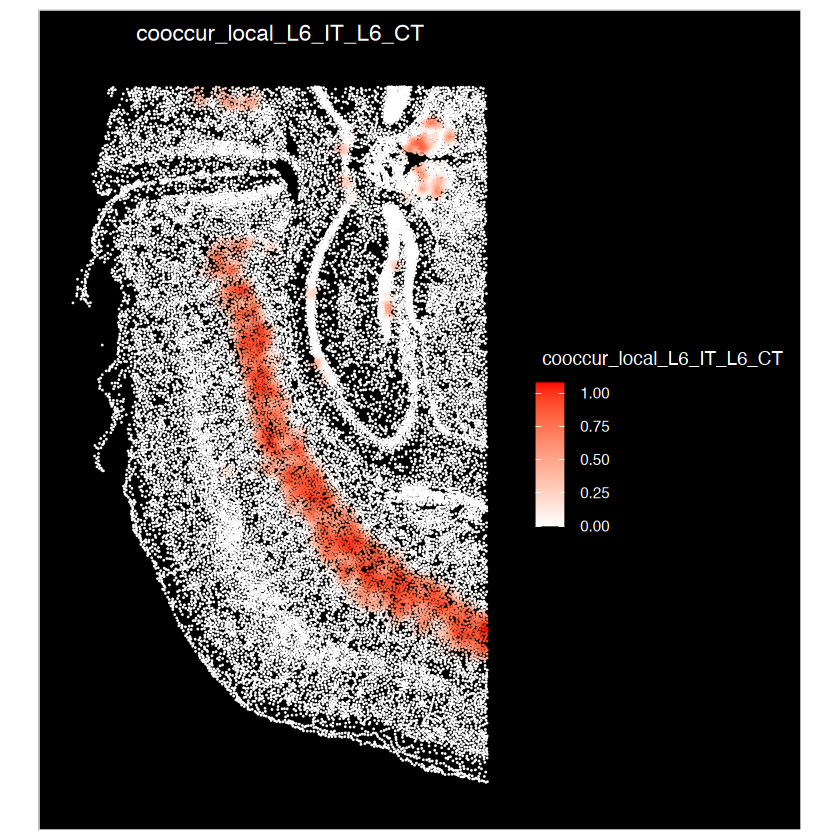

In [33]:
xenium.obj = AddMetaData(xenium.obj, cooccur_local_df)

g = ImageFeaturePlot(xenium.obj, 
                     features = gsub(" ", "_", paste0("cooccur_local_",cluster_x,"_",cluster_y)), 
                     #dark.background = F,
                     cols = c("white", "red"))
g

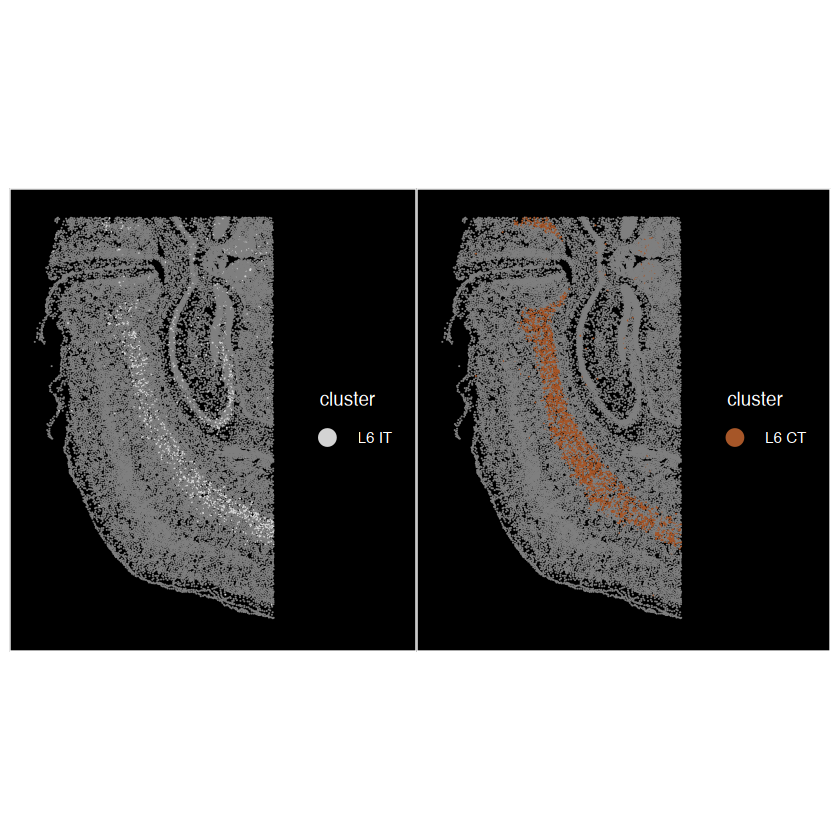

In [34]:

cluster_COLORS_ = cluster_COLORS[cluster_x]
g_x = ImageDimPlot(xenium.obj,
             fov = "fov", 
             size = 0.3,
             group.by = cluster_col)  &
  scale_fill_manual(values = cluster_COLORS_) &
  guides(fill = guide_legend(override.aes = list(size=5,
                                                 alpha = 1),
                             title = "cluster",
                             ncol = 1))
cluster_COLORS_ = cluster_COLORS[cluster_y]
g_y = ImageDimPlot(xenium.obj,
             fov = "fov", 
             size = 0.3,
             group.by = cluster_col)  &
  scale_fill_manual(values = cluster_COLORS_) &
  guides(fill = guide_legend(override.aes = list(size=5,
                                                 alpha = 1),
                             title = "cluster",
                             ncol = 1))
g_x + g_y

In [35]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS 15.3.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C

time zone: America/Denver
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] spacexr_2.2.1         spatialCooccur_0.1.0  ComplexHeatmap_2.18.0
 [4] circlize_0.4.15       ggplot2_3.4.4         SCP_0.5.6            
 [7] dplyr_1.1.4           magrittr_2.0.3        Seurat_5.0.0         
[10] SeuratObject_5.0.2    sp_2.1-2             

loaded via a namespace (and not attached):
  [1] fs_1.6.3                      matrixStats_1.2.0            
  [3] spatstat.sparse_3.1-0         bitops_1.0-7                 
  [5] enrichplot_1.22.0    